# Air Temperature

In this exercise we will inspect the dynamics of daily minimum and maximum air temperatures. We will calculate average Tmax and Tmin for each day of the year and we will also examine how residuals from these two variables are related to each other.


In [6]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [7]:
# Load sample data
df = pd.read_csv("../datasets/KS_Manhattan_6_SSW.csv")
df.head()


,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,53974,20031001,1.201,-96.61,39.1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1,53974,20031002,1.201,-96.61,39.1,18.9,2.5,10.7,11.7,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2,53974,20031003,1.201,-96.61,39.1,22.6,8.1,15.4,14.8,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
3,53974,20031004,1.201,-96.61,39.1,22.6,3.8,13.2,14.0,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
4,53974,20031005,1.201,-96.61,39.1,25.0,10.6,17.8,17.3,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [8]:
# Convert date string to pandas datetime format
df["LST_DATE"] = pd.to_datetime(df["LST_DATE"], format="%Y%m%d")
df["LST_DATE"].head() # CHeck our conversion.


0   2003-10-01
1   2003-10-02
2   2003-10-03
3   2003-10-04
4   2003-10-05
Name: LST_DATE, dtype: datetime64[ns]

In [9]:
# Convert missing values represented as -9999 to NaN
df[df == -9999] = np.nan


In [10]:
# Add year, month, and day of the year to summarize data in future steps.
df["YEAR"] = df["LST_DATE"].dt.year
df["MONTH"] = df["LST_DATE"].dt.month
df["DOY"] = df["LST_DATE"].dt.dayofyear


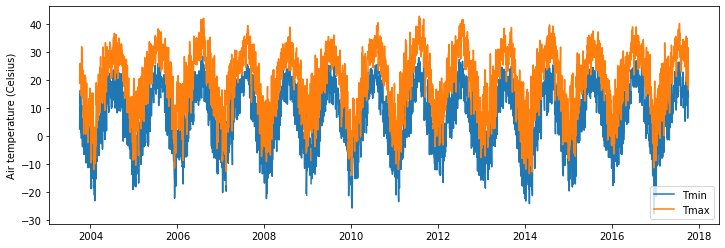

In [11]:
# Air temperature
plt.figure(figsize=(12,4))
plt.plot(df["LST_DATE"], df["T_DAILY_MIN"], label="Tmin")
plt.plot(df["LST_DATE"], df["T_DAILY_MAX"], label="Tmax")
plt.ylabel("Air temperature (Celsius)")
plt.legend()
plt.show()


## Compute annual average air temperature

To establish some predictive power in aour weather generator we need to extract the deterministic and stochastic components of the signal. 

In [103]:
# Get annual average Tmin and Tmax
T_avg_avg = df["T_DAILY_AVG"].median()
T_min_avg = df["T_DAILY_MIN"].median()
T_max_avg = df["T_DAILY_MAX"].median()

print("Tavg_avg:",T_avg_avg)
print("Tmin_avg:",T_min_avg)
print("Tmax_avg:",T_max_avg)


Tavg_avg: 14.2
Tmin_avg: 7.1
Tmax_avg: 21.3


In [15]:
# Difference between Tmax and Tmin
T_diff = df["T_DAILY_MAX"] - df["T_DAILY_MIN"]


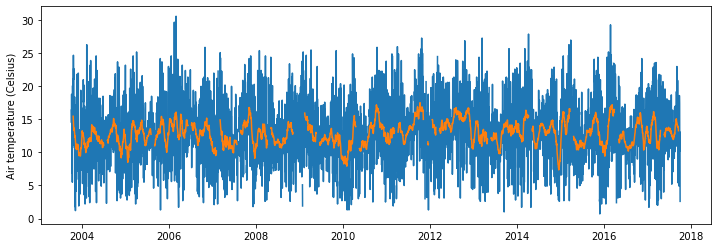

In [19]:
plt.figure(figsize=(12,4))
plt.plot(df["LST_DATE"], T_diff)
plt.plot(df["LST_DATE"], T_diff.rolling(window=30, center=True).mean())
plt.ylabel("Air temperature (Celsius)")
plt.show()


Investigate if there is autocorrelation between consecutive differences in Tmax and Tmin. If there is poor correlation, then that is a sign of randomness. If the differences are correlated, then we might need to account for this trend to better mimic the natural patterns.


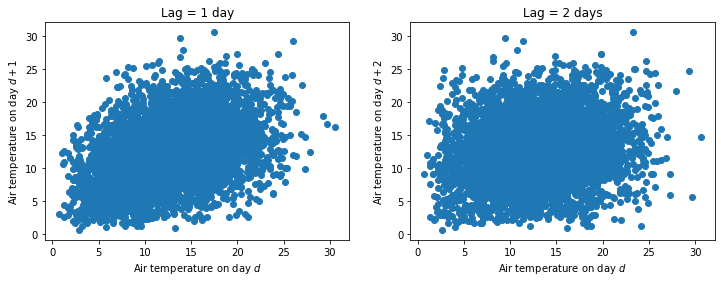

In [66]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Lag = 1 day")
plt.scatter(T_diff[0:-1],T_diff[1:])
plt.xlabel("Air temperature on day $d$")
plt.ylabel("Air temperature on day $d+1$")

plt.subplot(1,2,2)
plt.title("Lag = 2 days")
plt.scatter(T_diff[0:-2],T_diff[2:])
plt.xlabel("Air temperature on day $d$")
plt.ylabel("Air temperature on day $d+2$")
plt.show()


With a lag of 1 day we see a some positive trend, but it seems weak and probably not worth considering in our trivial example. This is even more clear with a lag of 2 days. This trends mean that the difference between Tmax and Tmin in one day are poorly correlated with the difference in Tmax and Tmin the next day. In principle this help us support our choice of modelling these fluctuations using a random process. 

>Note that the differences may be related to another variable, such as rainfall and solar radiation. 

Let's check out the histogram so that we can have a sound idea of the type of random process that we need to simulate.


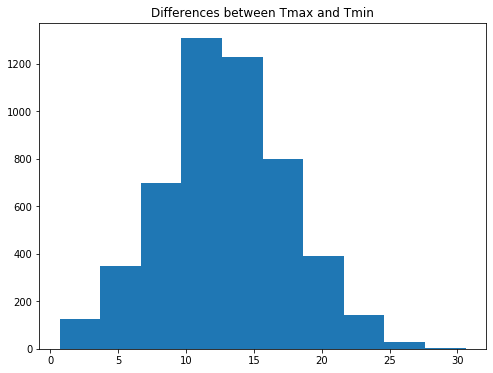

In [37]:
# Histogram
plt.figure(figsize=(8,6))
plt.title("Differences between Tmax and Tmin")
plt.hist(T_diff)
plt.show()


In [38]:
# Compute normal distribution parameters
T_diff_mean = T_diff.mean()
T_diff_std = T_diff.std()

print(T_diff_mean, 'Celsius')
print(T_diff_std, 'Celsius')

12.901122931442101 Celsius
4.660808691099936 Celsius


## Examine residuals

Residuals tmax: Mean= -0.019181784247878537 Std: 5.414114625572652
Residuals tmin: Mean= -0.0027578743096251766 Std: 4.879320798713006


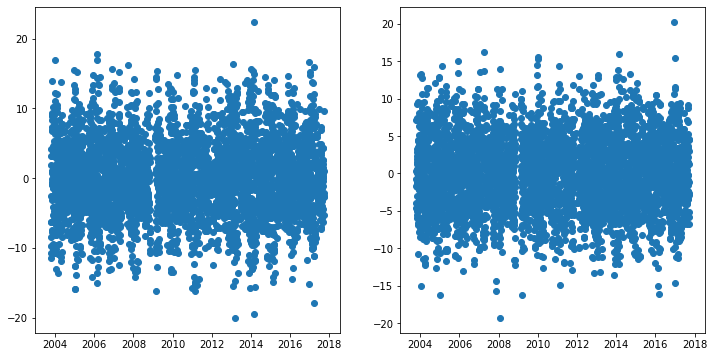

In [12]:

mean_tmax = df["T_DAILY_MAX"].rolling(window=30, center=True).mean()
mean_tmin = df["T_DAILY_MIN"].rolling(window=30, center=True).mean()

residuals_tmax = mean_tmax - df["T_DAILY_MAX"]
residuals_tmin = mean_tmin - df["T_DAILY_MIN"]

print("Residuals tmax: Mean=",residuals_tmax.mean(), "Std:",residuals_tmax.std())
print("Residuals tmin: Mean=",residuals_tmin.mean(), "Std:",residuals_tmin.std())

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(df["LST_DATE"],residuals_tmax)

plt.subplot(1,2,2)
plt.scatter(df["LST_DATE"],residuals_tmin)

plt.show()

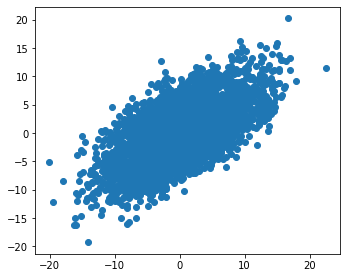

In [14]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.scatter(residuals_tmax, residuals_tmin)
plt.show()


## Compute Tmax and Tmin for each DOY

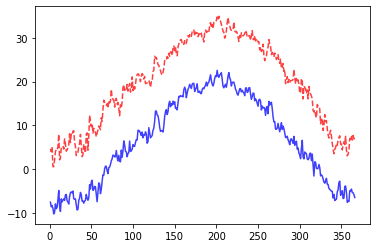

In [65]:
# Generate smooth
df_grouped = df.groupby(["DOY"]).mean()

plt.plot(df_grouped.index, df_grouped["T_DAILY_MIN"], '-b',  alpha=0.75, label='Tmin')
plt.plot(df_grouped.index, df_grouped["T_DAILY_MAX"], '--r', alpha=0.75, label='Tax')
plt.show()


In [69]:
# Occurrence of maximum values (on average)
print(df_grouped["T_DAILY_MIN"].rolling(window=15, center=True).mean().idxmax())
print(df_grouped["T_DAILY_MAX"].rolling(window=15, center=True).mean().idxmax())


199
199


In [70]:
# Occurrence of minimum values (on average)
print(df_grouped["T_DAILY_MIN"].rolling(window=15, center=True).mean().idxmin())
print(df_grouped["T_DAILY_MAX"].rolling(window=15, center=True).mean().idxmin())


8
8


## Compute annual thermal amplitude

To compute the amplitude we will first smooth the air temperature signal using a centered moving average. THen we have two options, computing the amplitude from records of 
Here there are two options: 1) computing the amplitude using a smoothed version of Tmin and Tmax, or 2) simply computing the average amplitude of each day on record. Let's try both and see if there is any difference. We should favor the easiest approach.


For the first approach, we will estimate the annual average thermal amplitude by first computing the amplitude for each day of the year, and then calculate the annual average. This approach removes some noise before calcualting the amplitude.


In [93]:
# Compute Tmax average amplitude by using de-noised signal
T_max_max = df_grouped["T_DAILY_MAX"].rolling(window=15, center=True).mean().max()
T_max_min = df_grouped["T_DAILY_MAX"].rolling(window=15, center=True).mean().min()
T_max_amplitude = ((T_max_max - T_max_min)/2)
print(T_max_amplitude)


14.834194139194146


In [95]:
# Compute Tmin average amplitude by using de-noised signal 
T_min_max = df_grouped["T_DAILY_MIN"].rolling(window=15, center=True).mean().max()
T_min_min = df_grouped["T_DAILY_MIN"].rolling(window=15, center=True).mean().min()
T_min_amplitude = ((T_min_max - T_min_min)/2)
print(T_min_amplitude)


14.545347985347988


The amplitude of Tmax and Tmin are remarkably similar, which means that we can probably take advantage of this fact to model air temperature using the same amplitude parameter.

## Build model for air temperature

A sinusoidal model is probably adequate to mimic the seasonal dynamics. This is the deterministic part of our model. The difference between our model and observations we will be attributed to random noise, or to more complicated relationships that go beyond the scope of this exercise.

$$ T(t) = T_{avg} + A \; sin \Bigg[2 \pi (\frac{DOY}{365} + \phi + \frac{\pi}{2}) \Bigg] + \epsilon $$


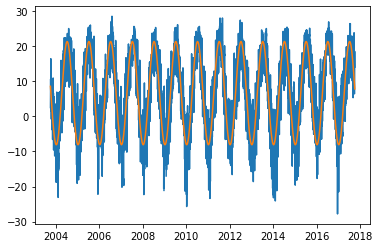

In [96]:
# Get amplitude of the sinusoidal pattern
dates = df["LST_DATE"]

# Get day of the year for each input date
doy = df["LST_DATE"].dt.dayofyear

T_avg = 6.6
A = 14.7
phase = 8
T = T_avg + A * np.sin(2*np.pi*( (doy-phase)/365) - np.pi/2)

plt.plot(df["LST_DATE"], df["T_DAILY_MIN"], label="Tmin")
plt.plot(dates,T)
plt.show()

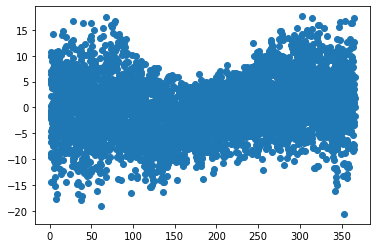

In [105]:
# Compute noise
plt.scatter(doy,df["T_DAILY_MIN"] - T)
plt.show()